# Baseline

## Load datasets

In [1]:
import torch
from torch import nn
from torch.utils import data
import torchvision as vis
import sys

# torch.manual_seed(117850791)
is_windows = sys.platform == "win32"
has_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if has_cuda else "cpu")
device

device(type='cuda', index=0)

In [2]:
from PIL import Image
import os

class FlatImageData(vis.datasets.VisionDataset):
  def __init__(self, root, transform, validation_reserved_images=31136):
    self.root = root
    self.images = os.listdir(root)
    self.images.sort(key=lambda x: int(x[6:-5]))# sort by frame no.
    self.transform = transform
    self.training_mode = True
    self.reserved_images = validation_reserved_images
        
  def __len__(self):
    if self.training_mode:
      return len(self.images) - self.reserved_images
    else:
      return self.reserved_images
    
  def pil_loader(self, path: str) -> Image.Image:
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        img = Image.open(f)
        return img.convert('RGB')

  def __getitem__(self, index):
    if self.training_mode:
      index += self.reserved_images
    
    image_name = self.images[index]
    image_path = f"{self.root}/{image_name}"
    image = self.pil_loader(image_path)
    if self.transform is not None:
         image = self.transform(image)

    return image

  def collate_fn(batch):
      return torch.as_tensor(batch)

In [8]:
input_size = 64

dataset = FlatImageData(root="/home/ubuntu/data/knnw-256p",
                             transform=vis.transforms.Compose([
                               vis.transforms.RandomHorizontalFlip(),
                               vis.transforms.RandomApply(nn.ModuleList([
                                 vis.transforms.RandomAffine(degrees=15),
                                 vis.transforms.CenterCrop((200, 200))
                               ]), p=0.5),
                               vis.transforms.ToTensor(),
                               nn.AdaptiveAvgPool2d((input_size, input_size)),
                             ])
                            )
dataset

Dataset FlatImageData
    Number of datapoints: 160745
    Root location: /home/ubuntu/data/knnw-256p

## Train Model

In [3]:
import os
model_store = "model_checkpoints"

class StoredModel:
  def __init__(self, model, optimizer, scheduler, criterion):
    self.model = model
    self.optimizer = optimizer
    self.scheduler = scheduler
    self.criterion = criterion

In [9]:
from torch.nn import functional as F
from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

class BetaVAE(nn.Module):

    num_iter = 0 # Global static variable to keep track of iterations

    def __init__(self,
                 in_channels: int,
                 latent_dim: int,
                 hidden_dims: List = None,
                 beta: int = 4,
                 gamma:float = 1000.,
                 max_capacity: int = 25,
                 capacity_max_iter: int = 1e5,
                 loss_type:str = 'B',
                 **kwargs) -> None:
        super(BetaVAE, self).__init__()

        self.latent_dim = latent_dim
        self.beta = beta
        self.gamma = gamma
        self.loss_type = loss_type
        self.C_max = torch.Tensor([max_capacity])
        self.C_stop_iter = capacity_max_iter

        modules = []
        if hidden_dims is None:
            hidden_dims = [32, 64, 128, 256, 512]

        # Build Encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv2d(in_channels, out_channels=h_dim,
                              kernel_size= 3, stride= 2, padding  = 1),
                    nn.BatchNorm2d(h_dim),
                    nn.LeakyReLU())
            )
            in_channels = h_dim
            
        modules.append(nn.Flatten())

        self.encoder = nn.Sequential(*modules)
        
        self.fc_mu = nn.Linear(hidden_dims[-1]*(input_size // 32) ** 2, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*(input_size // 32) ** 2, latent_dim)


        # Build Decoder
        modules = []

        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1] * (input_size // 32) ** 2)

        hidden_dims.reverse()

        for i in range(len(hidden_dims) - 1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(hidden_dims[i],
                                       hidden_dims[i + 1],
                                       kernel_size=3,
                                       stride = 2,
                                       padding=1,
                                       output_padding=1),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU())
            )

        self.decoder = nn.Sequential(*modules)

        self.final_layer = nn.Sequential(
                            nn.ConvTranspose2d(hidden_dims[-1],
                                               hidden_dims[-1],
                                               kernel_size=3,
                                               stride=2,
                                               padding=1,
                                               output_padding=1),
                            nn.BatchNorm2d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv2d(hidden_dims[-1], out_channels= 3,
                                      kernel_size= 3, padding= 1))

    def encode(self, inputs: Tensor) -> List[Tensor]:
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(inputs)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return (inputs, mu, log_var)

    def decode(self, z: Tensor) -> Tensor:
        result = self.decoder_input(z)
        result = result.view(-1, 512, (input_size // 32), (input_size // 32))
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu: Tensor, logvar: Tensor) -> Tensor:
        """
        Will a single z be enough ti compute the expectation
        for the loss??
        :param mu: (Tensor) Mean of the latent Gaussian
        :param logvar: (Tensor) Standard deviation of the latent Gaussian
        :return:
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, inputs: Tensor, **kwargs) -> Tensor:
        inputs, mu, log_var = self.encode(inputs)
        z = self.reparameterize(mu, log_var)
        
        self.current_inputs = inputs
        self.current_mu = mu
        self.current_log_var = log_var
        self.current_recon = self.decode(z)
        self.current_z = z
        
        return self.current_recon

    def loss(self, *args, **kwargs) -> dict:
        self.num_iter += 1
        recons = self.current_recon
        input = self.current_inputs
        mu = self.current_mu
        log_var = self.current_log_var
        kld_weight = kwargs['kld_weight']  # Account for the minibatch samples from the dataset
        
        # since the image value is normalized between 0~1, BCE loss is better
        batch_size = recons.shape[0]
        recons_loss =F.binary_cross_entropy_with_logits(recons, input, reduction='sum') / batch_size
  
#         w_loss = torch.mean(torch.sum(mu ** 2 + (log_var.exp().sqrt() - 1) ** 2, dim = 1), dim = 0)
        w_loss = torch.mean(torch.sum(self.current_z ** 2 + (log_var.exp().sqrt() - 1) ** 2, dim = 1), dim = 0)

        if self.loss_type == 'H': # https://openreview.net/forum?id=Sy2fzU9gl
            loss = recons_loss + self.beta * w_loss
        elif self.loss_type == 'B': # https://arxiv.org/pdf/1804.03599.pdf
            self.C_max = self.C_max.to(input.device)
            C = torch.clamp(self.C_max/self.C_stop_iter * self.num_iter, 0, self.C_max.data[0])
            loss = recons_loss + self.gamma * kld_weight * (kld_loss - C).abs()
        else:
            raise ValueError('Undefined loss type.')

        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'W':w_loss}

    def sample(self,
               num_samples:int,
               current_device: int, **kwargs) -> Tensor:
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x: Tensor, **kwargs) -> Tensor:
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]

In [6]:
def load_model(model_id, specific_epoch = None):
  global optimizer, scheduler
  epoch_start = -1
  for checkpoint in os.listdir(f"{model_store}/{model_id}"):
    if not checkpoint.startswith("epoch"):
      continue
    epoch = int(checkpoint.split("_")[1])
    if specific_epoch is None:
      # find the latest
      if epoch > epoch_start:
        epoch_start = epoch
        last_checkpoint = checkpoint
    else:
      if epoch == specific_epoch:
        epoch_start = epoch
        last_checkpoint = checkpoint
        break

  if epoch_start == -1:
    print(f"No checkpoints available for {model_id}!")
    return -1, None
  else:
    epoch_start += 1
    print(f"resuming from last checkpoint {last_checkpoint}")
    data = torch.load(f"{model_store}/{model_id}/{last_checkpoint}")
    
    model = data.model
    optimizer = data.optimizer
    scheduler = data.scheduler
    criterion = data.criterion
    
    model.to(device)
    return epoch_start, model, criterion

### Resume from checkpoint or a new model?

#### train a new model

In [12]:
from torchsummary import summary_string
model_id = "baseline_BCE_W_loss_64x64_10_latent"

model = BetaVAE(3, 10, loss_type="H")

epoch_start = 0
model.to(device)
print(model)

model_spec = summary_string(model, (3, 64, 64))[0]
print(model_spec)

BetaVAE(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Seque

In [11]:
os.mkdir(f"{model_store}/{model_id}")
# save model summary to a txt file
with open(f"{model_store}/{model_id}/model_spec.txt", "w") as file:
  file.write(str(model) + "\n")
  file.write(model_spec)

#### load a trained model from checkpoint 

In [7]:
model_id = "baseline_BCE_B_loss_128x128_10_latent"
epoch_start, model, criterion = load_model(model_id)

resuming from last checkpoint epoch_04_tr-loss_25884.417728


### Start training

In [48]:
# clear GPU cache
if has_cuda:
  torch.cuda.empty_cache()

In [13]:
train_dataloader_args = dict(batch_size=128,
                             num_workers=0 if is_windows else 4) if has_cuda else dict(batch_size=64)
train_dataloader_args["shuffle"] = True

train_dataloader = data.DataLoader(dataset, **train_dataloader_args)

In [14]:
from torch import optim
from itertools import chain

num_epochs = 40

if epoch_start == 0:
  # define only at the start of the training
  
  regularization = 2e-5
#   learning_rate = 1e-1
#   optimizer = optim.SGD(chain(model.parameters(), criterion.parameters()),
#                          lr = learning_rate, momentum=0.9, weight_decay=regularization, nesterov=True)
  learning_rate = 1e-3
  optimizer = optim.Adam(model.parameters(),
                         lr = learning_rate, weight_decay=regularization)
#   scheduler = optim.lr_scheduler.StepLR(optimizer, step_size = 20, gamma = 0.5)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
  

scaler = torch.cuda.amp.GradScaler() # mix-precision training

with open(f"{model_store}/{model_id}/training_params.txt", "w") as file:
  file.write(f"num_epochs = {num_epochs}\n")
  file.write(f"optimizer = {optimizer}\n")
  file.write(f"scheduler = {type(scheduler).__name__}({scheduler.state_dict()})\n")

In [41]:
for param_group in optimizer.param_groups:
  param_group['lr'] = 1e-3
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

In [16]:
from tqdm import tqdm
import sys
import json

print(f"Model: {model_id}. Training for {num_epochs} epochs", file=sys.stderr)

for epoch in range(epoch_start, num_epochs):
  print(f"Epoch {epoch}", file=sys.stderr)
  
  # set model in training mode
  model.train()
  training_loss = 0.0
  reconstruction_loss = 0.0
  w_loss = 0.0

  for x in tqdm(train_dataloader, desc="Train"):
    optimizer.zero_grad() # clear calculated gradients

    x = x.to(device)
    
    with torch.cuda.amp.autocast():
      output = model(x)
      all_loss = model.loss(kld_weight=1.0)
      loss = all_loss["loss"]
    
    # backpropo loss and accumuate loss stat
    scaler.scale(loss).backward()    
    
    training_loss += loss.detach().item() # otherwise this would be a tensor
    reconstruction_loss += all_loss['Reconstruction_Loss'].detach().item()
    w_loss += all_loss['W'].detach().item()

    scaler.step(optimizer)
    scaler.update()
    
  # let scheduler know it's the next epoch
  training_loss /= len(train_dataloader)
  reconstruction_loss /= len(train_dataloader)
  w_loss /= len(train_dataloader)
  
  scheduler.step(training_loss)
  
  log_str = json.dumps({
    "Epoch": epoch,
    "training loss": round(training_loss, 6),
    "reconstruction loss": round(reconstruction_loss, 6),
    "W loss": round(w_loss, 6),
    "Learning rate": scheduler._last_lr
  })

  with open(f"{model_store}/{model_id}/training_logs.txt", "a") as log_file:
    log_file.write(log_str + "\n")
  print(log_str, file=sys.stderr)
  
  torch.save(StoredModel(model, optimizer, scheduler, None),
             f"{model_store}/{model_id}/epoch_{epoch:02d}" +\
             f"_tr-loss_{training_loss:.6f}")

Model: baseline_BCE_W_loss_64x64_10_latent. Training for 40 epochs
Epoch 0
Train: 100%|██████████| 1256/1256 [02:31<00:00,  8.28it/s]
{"Epoch": 0, "training loss": 7004.388014, "reconstruction loss": 6954.256692, "W loss": 12.532831, "Learning rate": [0.001]}
Epoch 1
Train: 100%|██████████| 1256/1256 [02:29<00:00,  8.37it/s]
{"Epoch": 1, "training loss": 6904.991382, "reconstruction loss": 6859.120764, "W loss": 11.467654, "Learning rate": [0.001]}
Epoch 2
Train: 100%|██████████| 1256/1256 [02:30<00:00,  8.35it/s]
{"Epoch": 2, "training loss": 6879.275655, "reconstruction loss": 6835.078107, "W loss": 11.049386, "Learning rate": [0.001]}
Epoch 3
Train: 100%|██████████| 1256/1256 [02:30<00:00,  8.37it/s]
{"Epoch": 3, "training loss": 6858.03056, "reconstruction loss": 6814.594643, "W loss": 10.85898, "Learning rate": [0.001]}
Epoch 4
Train: 100%|██████████| 1256/1256 [02:30<00:00,  8.34it/s]
{"Epoch": 4, "training loss": 6837.81927, "reconstruction loss": 6794.978139, "W loss": 10.71028

KeyboardInterrupt: 

In [8]:
from math import floor
scene_changes = []
with open("data/scene-change.csv") as f:
    lines = f.readlines()
    for line in lines[1:]:
        scenes = line.split(',')
        scene_changes.append([floor(int(scenes[0][6:12])/25*30+25), floor(int(scenes[1][6:12])/25*30+32)])

In [18]:
latent_mu, latent_log_var = torch.load(f"temp_store/many_to_one_mean_H_loss_01_latent_vectors")

In [19]:
from tqdm import tqdm

L2_divergence_latent = list()

for i in tqdm(range(31136 - 1), desc="L2"):
  image_1 = torch.cat((latent_mu[i], torch.exp(latent_log_var[i]).sqrt()))
  image_2 = torch.cat((latent_mu[i + 1], torch.exp(latent_log_var[i + 1]).sqrt()))
  
  diff = (image_1 - image_2).flatten()
  
  L2_divergence_latent.append(torch.linalg.norm(diff, 2).item())

L2: 100%|██████████| 31135/31135 [00:03<00:00, 9045.39it/s] 


In [20]:
import numpy as np
L2_divergence_latent = np.array(L2_divergence_latent)

In [21]:
max_l2_per_scene_change = list()

for start_id, end_id in scene_changes:
  start_id -= 1
  max_l2_per_scene_change.append(max(L2_divergence_latent[start_id: end_id]))
  
max_l2_per_scene_change = np.array(sorted(max_l2_per_scene_change, reverse=True))

In [22]:
correct = list()
total = list()

for i, divergence in enumerate(max_l2_per_scene_change):
  correct.append(i + 1)
  total.append((L2_divergence_latent >= divergence).sum())

In [23]:
total[150]

469

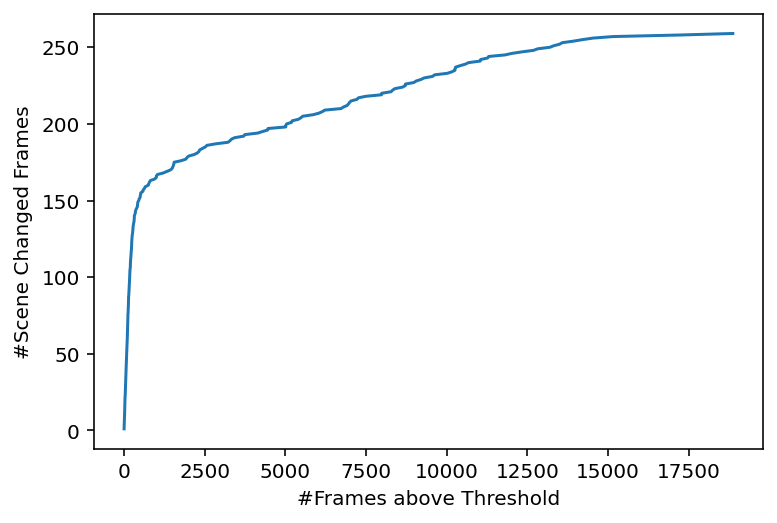

In [25]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.set_ylabel('#Scene Changed Frames')
ax1.set_xlabel('#Frames above Threshold')
plt.plot(total, correct)

In [65]:
L2_divergence_raw = list()

image_1 = dataset[0].to(device)

for i in tqdm(range(len(dataset) - 1), desc="L2"):
  image_2 = dataset[i + 1].to(device)
  
  diff = (image_1 - image_2).flatten()
  
  L2_divergence_raw.append(torch.linalg.norm(diff, 2).cpu().item())
  
  image_1 = image_2

L2: 100%|██████████| 191880/191880 [48:40<00:00, 65.69it/s]


In [67]:
torch.save(torch.tensor(L2_divergence_raw), f"temp_store/{model_id}/l2_divergence_raw")

In [64]:
normalize = lambda X, mn, mx: [(x - mn)/(mx - mn) for x in X]

63.88896179199219